# Лабораторная работа №4

ФИО:  **Смирнов Александр Андреевич**
Группа: **БИВТ-20-1**

Отправлять можно следующими способами (**обязательно указать свое ФИО и группу в каком-либо виде**):
1. Создать **приватный** репозиторий на github, добавить меня по нику (l3lush) в Collaborators (Settings -> Collaborators -> Add people)
2. Отправить заполненный ноутбук мне на почту avmysh@gmail.com, либо m1603956@edu.misis.ru
3. Отправить заполненный ноутбук мне в тг @l3lush. 

**Deadline**:
- hard -- **04.06.2023 23:59** (дедлайн теперь один)


**Что необходимо сделать** (можете вдохновляться ноутбуками для семинара, они должны помочь):
1. Загрузить датасет (вариант смотреть [здесь](https://docs.google.com/spreadsheets/d/1pFk1qZJtMrV8GWUmdSjV5Kz6JnFdBQDShErFZ337FDc/edit?usp=sharing))
2. Описать кратенько словами датасет, описать поставку задачи, что от чего отличаем, привести примеры картинок (картинки можно визуализировать после шага 3, когда у вас будет красивый датасет).
3. Оформить датасет в виде объекта класса Dataset из PyTorch (обязательно надо сделать препроцессинг данных: нормализовать данные, добавить аугментации к данным и пр.).
4. Оформить датасет из шага 3 в Dataloader.
5. Реализовать архитектуру собственной нейросети и натренировать ее на датасете (можно не обучать 1000 эпох, достаточно 10 эпох, но чтобы метрики начали улучшаться).
6. Обучить нейросеть, используя Transfer Learning. Модель можно выбрать на свой вкус (список всех моделей, доступных в torchvision есть [тут](https://pytorch.org/vision/stable/models.html)).
7. Посчитать метрики качества финальной модели, сделать выводы.

**Замечание**  
Если понимаете, что данные слишком много весят, или с датасетом что-то не так, можете брать любой другой.  

P.S. Чтобы не ждать века, тренируйте модели на Colab с использованием GPU (Runtime -> Change runtime type -> GPU)  
P.S.S. Сохраняйте вывод ячеек и пушьте вместе с ним, в противном случае я не смогу нормально проверить все работы, если буду запускать все ноутбуки и ждать обучение моделей

# 1. Загрузка датасета

In [2]:
!pip install -q datasets

from datasets import load_dataset

dataset = load_dataset('Matthijs/snacks') 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.2 MB/s eta 0:00:00


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset snacks downloaded and prepared to /root/.cache/huggingface/datasets/Matthijs___snacks/default/0.0.1/c0ce49075aa469a098a5f2e3455941c894e02e1c9bf642d4d33e6c51460ff590. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4838
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 952
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 955
    })
})

# 2. Описание
Датасет Matthijs/snacks имеет 20 классов еды. Например, яблоко, банан, салат и т.д. (классы представлены далее). Датасет содержит данные для обучения, тестироания и ввалидации нейросети.

В данной лабораторной работе я буду пытаться отличать описанные ниже классы классы друг от друга.

In [4]:
labels = dataset["test"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    print(i, label)
    label2id[label] = i
    id2label[i] = label

0 apple
1 banana
2 cake
3 candy
4 carrot
5 cookie
6 doughnut
7 grape
8 hot dog
9 ice cream
10 juice
11 muffin
12 orange
13 pineapple
14 popcorn
15 pretzel
16 salad
17 strawberry
18 waffle
19 watermelon


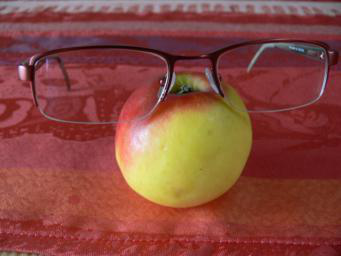

In [10]:
dataset['train'][1]['image']

# 3-4. Оформление датасета

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

In [8]:
class ImageDataset(torch.utils.data.Dataset):

  def __init__(self, input_data):
        
      self.input_data = input_data
      
      self.transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

  def __len__(self):
      return len(self.input_data)
    
  def get_images(self, idx):
      return self.transform(self.input_data[idx]['image'])
  
  def get_labels(self, idx):
      return self.input_data[idx]['label']
  
  def __getitem__(self, idx):
      # Get input data in a batch
      train_images = self.get_images(idx)
      train_labels = self.get_labels(idx)

      return train_images, train_labels

In [9]:
train_dataset = ImageDataset(dataset["train"])
test_dataset = ImageDataset(dataset["test"])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = dataset["test"].features["label"].names
dataset_sizes = {
    'train': len(dataset['train']),
    'test': len(dataset['test']),
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

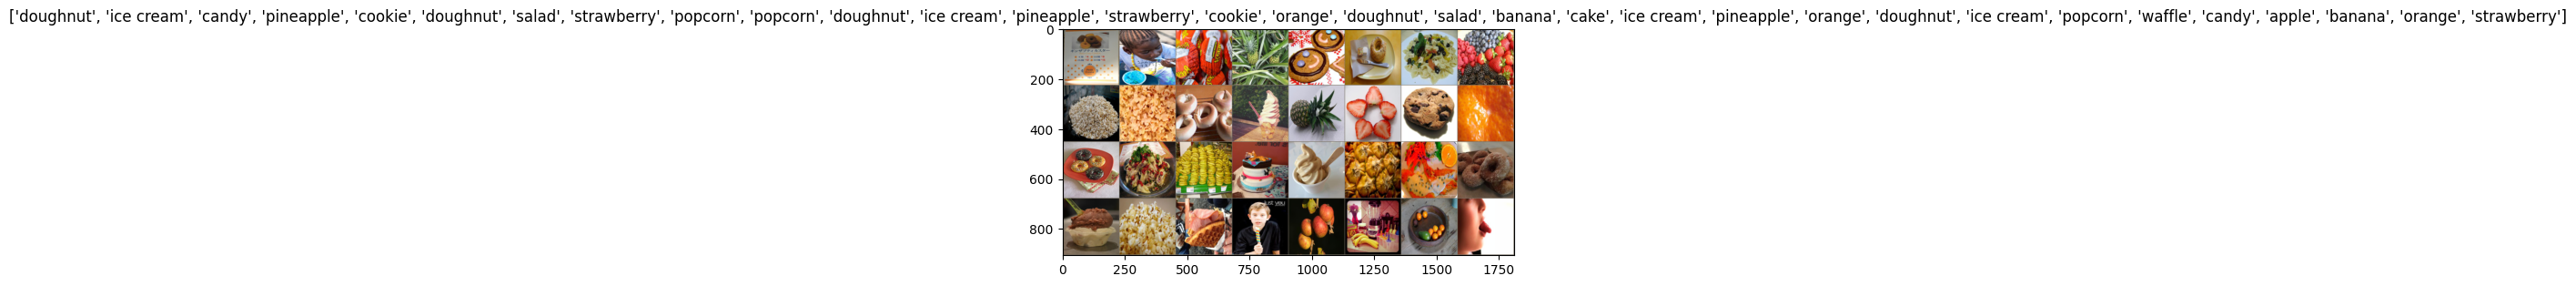

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0)) 
    #mean = np.array([0.5, 0.5, 0.5])
    #std = np.array([0.5, 0.5, 0.5])
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(train_dataloader))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# 5. Реализация собственной нейросети

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            current_dataloader = train_dataloader
            if phase == 'test':
                current_dataloader = test_dataloader


            for inputs, labels in current_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)


                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if ((phase == 'test') & (epoch_acc > best_acc)):
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model


In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 32, 3),
    nn.ELU(),
    nn.Conv2d(32, 32, 3),
    nn.ELU(),
    nn.MaxPool2d(4),

    nn.Conv2d(32, 64, 3),
    nn.ELU(),
    nn.Conv2d(64, 64, 3),
    nn.ELU(),
    nn.MaxPool2d(4),


    nn.BatchNorm2d(64),

    nn.Softmax2d(),

    nn.Dropout2d(),
    nn.Flatten(),

    nn.Linear(9216, 32),
    nn.Linear(32, 20),
)


model = model.to(device)

criterion = nn.CrossEntropyLoss().to(device)

optimizer_ft = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#optimizer_ft = Adam(model.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)
model_fitted = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 2.8785 Acc: 0.1002
test Loss: 2.7037 Acc: 0.1418

Epoch 1/9
----------
train Loss: 2.7447 Acc: 0.1463
test Loss: 2.5980 Acc: 0.1954

Epoch 2/9
----------
train Loss: 2.6833 Acc: 0.1711
test Loss: 2.5522 Acc: 0.1964

Epoch 3/9
----------
train Loss: 2.5261 Acc: 0.2177
test Loss: 2.4287 Acc: 0.2437

Epoch 4/9
----------
train Loss: 2.4830 Acc: 0.2226
test Loss: 2.4135 Acc: 0.2458

Epoch 5/9
----------
train Loss: 2.4562 Acc: 0.2371
test Loss: 2.4040 Acc: 0.2595

Epoch 6/9
----------
train Loss: 2.4357 Acc: 0.2408
test Loss: 2.4040 Acc: 0.2500

Epoch 7/9
----------
train Loss: 2.4272 Acc: 0.2447
test Loss: 2.3891 Acc: 0.2668

Epoch 8/9
----------
train Loss: 2.4341 Acc: 0.2487
test Loss: 2.3896 Acc: 0.2595

Epoch 9/9
----------
train Loss: 2.4094 Acc: 0.2474
test Loss: 2.3966 Acc: 0.2563

Training complete in 7m 54s
Best val Acc: 0.266807


In [ ]:
def predict(img):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    img = transform(img)
    output = model_fitted(img.unsqueeze(0).to(device))
    prediction = output.argmax(dim=1).item()

    return id2label[prediction]

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

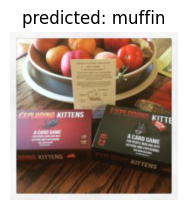

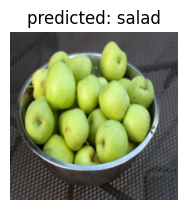

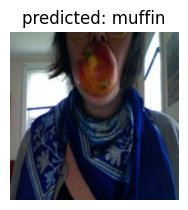

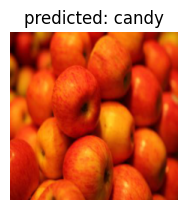

In [ ]:
visualize_model(model_fitted, 4)

waffle


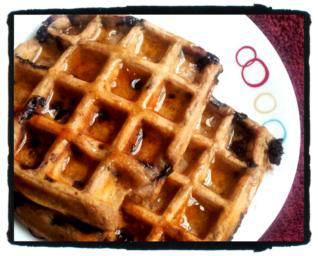

In [ ]:
num = 900
print(predict(dataset['test'][num]['image']))
dataset['test'][num]['image']

# 6. Transfer Learning

## ResNet-18

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 20)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss().to(device)

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.5807 Acc: 0.5389
test Loss: 2.0074 Acc: 0.5231

Epoch 1/9
----------
train Loss: 1.0060 Acc: 0.7121
test Loss: 1.7551 Acc: 0.5609

Epoch 2/9
----------
train Loss: 0.4518 Acc: 0.8702
test Loss: 0.6983 Acc: 0.8057

Epoch 3/9
----------
train Loss: 0.2464 Acc: 0.9326
test Loss: 0.6705 Acc: 0.8025

Epoch 4/9
----------
train Loss: 0.1894 Acc: 0.9514
test Loss: 0.6601 Acc: 0.8130

Epoch 5/9
----------
train Loss: 0.1831 Acc: 0.9568
test Loss: 0.6493 Acc: 0.8183

Epoch 6/9
----------
train Loss: 0.1769 Acc: 0.9556
test Loss: 0.6345 Acc: 0.8256

Epoch 7/9
----------
train Loss: 0.1820 Acc: 0.9543
test Loss: 0.6701 Acc: 0.8088

Epoch 8/9
----------
train Loss: 0.1677 Acc: 0.9597
test Loss: 0.6474 Acc: 0.8183

Epoch 9/9
----------
train Loss: 0.1774 Acc: 0.9556
test Loss: 0.6708 Acc: 0.8109

Training complete in 7m 49s
Best val Acc: 0.825630


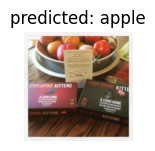

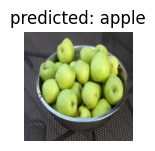

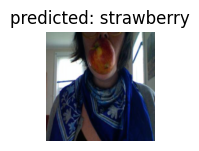

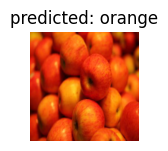

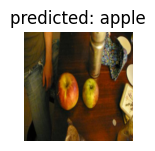

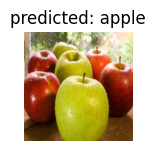

In [ ]:
visualize_model(model_ft)

## ResNet-152

In [ ]:
model_conv = torchvision.models.resnet152(pretrained=True)

num_ftrs = model_conv.fc.in_features

model_conv.fc = nn.Linear(num_ftrs, 20)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=2, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:00<00:00, 332MB/s]


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.9681 Acc: 0.5661
test Loss: 1.2403 Acc: 0.7731

Epoch 1/9
----------
train Loss: 1.1043 Acc: 0.7753
test Loss: 0.9147 Acc: 0.7983

Epoch 2/9
----------
train Loss: 0.9120 Acc: 0.8084
test Loss: 0.8995 Acc: 0.8067

Epoch 3/9
----------
train Loss: 0.8905 Acc: 0.8067
test Loss: 0.8800 Acc: 0.8067

Epoch 4/9
----------
train Loss: 0.8828 Acc: 0.8098
test Loss: 0.8848 Acc: 0.8078

Epoch 5/9
----------
train Loss: 0.8756 Acc: 0.8144
test Loss: 0.8703 Acc: 0.7983

Epoch 6/9
----------
train Loss: 0.8784 Acc: 0.8103
test Loss: 0.8872 Acc: 0.8088

Epoch 7/9
----------
train Loss: 0.8819 Acc: 0.8117
test Loss: 0.8624 Acc: 0.8088

Epoch 8/9
----------
train Loss: 0.8704 Acc: 0.8165
test Loss: 0.8642 Acc: 0.8183

Epoch 9/9
----------
train Loss: 0.8759 Acc: 0.8148
test Loss: 0.8771 Acc: 0.8078

Training complete in 24m 49s
Best val Acc: 0.818277


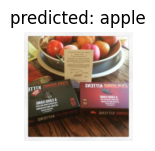

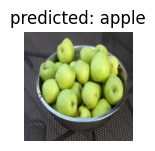

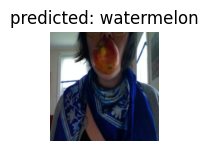

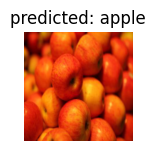

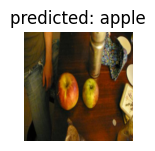

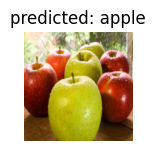

In [ ]:
visualize_model(model_conv)

#7. Выводы

## Собственная модель

###Train 
Loss: 2.4272 Acc: 0.2447

###Test 
Loss: 2.3891 Acc: 0.2668

Собственная модель показала плохие результаты. Возможно стоит изменить препроцессинг данных и перемешать все секции датасета и уже от туда выбрать наборы для обучения и тестов.

## ResNet-18

###Train 
Loss: 0.1769 Acc: 0.9556

###Test 
Loss: 0.6345 Acc: 0.8256

## ResNet-152

###Train 
Loss: 0.8704 Acc: 0.8165

###Test 
Loss: 0.8642 Acc: 0.8183

Модели предобученные на ResNet-18 и ResNet-152 показали неплохие результаты (более 0,8 accuracy). Однако видно, что модель ResNet-18 переобучилась.